# Milestone 1

The objective of this project is to analyze the modelled daily rainfall dataset over NSW, Australia, spanning 1889- 2014. The dataset can be found [here](https://figshare.com/articles/dataset/Daily_rainfall_over_NSW_Australia/14096681). 

### Imports

In [1]:
import re
import os
import glob
import zipfile
import requests
from urllib.request import urlretrieve
import json
import pandas as pd
import dask
import dask.dataframe as dd
import seaborn as sns

### Variables

In [2]:
# Figshare article metadata
article_id = 14096681
url = f"https://api.figshare.com/v2/articles/{article_id}"
headers = {"Content-Type": "application/json"}
output_directory = "figsharerainfall/"

### 3. Send API request to Figshare to download rainfall data 

We will download the data from [figshare](https://figshare.com/articles/dataset/Daily_rainfall_over_NSW_Australia/14096681) using [figshare API](https://docs.figshare.com/).

In [3]:
response = requests.request("GET", url, headers=headers)
data = json.loads(response.text)  # articles data
files = data["files"]             # list of files
files[3] # target file (data.zip)

{'id': 26766812,
 'name': 'data.zip',
 'size': 814041183,
 'is_link_only': False,
 'download_url': 'https://ndownloader.figshare.com/files/26766812',
 'supplied_md5': 'b517383f76e77bd03755a63a8ff83ee9',
 'computed_md5': 'b517383f76e77bd03755a63a8ff83ee9'}

### Collect data.zip folder from the list of `files` 

In [4]:
%%time
files_to_dl = ["data.zip"]
for file in files:
    if file["name"] in files_to_dl:
        os.makedirs(output_directory, exist_ok=True)
        # Download data.zip
        urlretrieve(file["download_url"], output_directory + file["name"])

CPU times: user 3.83 s, sys: 6.57 s, total: 10.4 s
Wall time: 36.7 s


### Unzip files from `data.zip` folder

In [5]:
%%time
with zipfile.ZipFile(os.path.join(output_directory, "data.zip"), 'r') as f:
    f.extractall(output_directory + "/data")

CPU times: user 14.6 s, sys: 1.99 s, total: 16.6 s
Wall time: 18.7 s


### 4. Combining csv's in `data` folder

In [6]:
%%time
## merging files
files = glob.glob('figsharerainfall/data/*.csv')
# Exclude observed_daily_rainfall from our analysis
files = [file for file in files if file != 'figsharerainfall/data/observed_daily_rainfall_SYD.csv']
df = pd.concat((pd.read_csv(file, index_col=0) 
                .assign(model=re.findall(r'[^\/]+(?=\_daily_rainfall_NSW.csv)', file)[0])
                for file in files)
              )
df.to_csv("figsharerainfall/combined_data.csv")

CPU times: user 5min 51s, sys: 13.7 s, total: 6min 5s
Wall time: 6min 13s


| Team Member       | Operating System | RAM  | Processor | Is SSD | Time taken |
|-------------------|------------------|------|-----------|--------|------------|
| Karanpreet Kaur   |                  |      |           |        |            |
| Melisa Maidana    | mac              | 8 GB | M1        | yes    |            |
| Nagraj Rao        |                  |      |           |        |            |
| Ting Zhe (TZ) Yan | mac              | 8 GB | M1        | yes    |            |

In [7]:
%%sh
du -sh figsharerainfall/combined_data.csv

5.6G	figsharerainfall/combined_data.csv


In [8]:
print(df.shape)

(62467843, 6)


In [9]:
df.head()

,lat_min,lat_max,lon_min,lon_max,rain (mm/day),model
time,,,,,,
1889-01-01 12:00:00,-35.439867,-33.574619,141.5625,143.4375,4.244226e-13,MPI-ESM-1-2-HAM
1889-01-02 12:00:00,-35.439867,-33.574619,141.5625,143.4375,4.217326e-13,MPI-ESM-1-2-HAM
1889-01-03 12:00:00,-35.439867,-33.574619,141.5625,143.4375,4.498125e-13,MPI-ESM-1-2-HAM
1889-01-04 12:00:00,-35.439867,-33.574619,141.5625,143.4375,4.251282e-13,MPI-ESM-1-2-HAM
1889-01-05 12:00:00,-35.439867,-33.574619,141.5625,143.4375,4.270161e-13,MPI-ESM-1-2-HAM


### 5. Load the combined CSV to memory and perform a simple EDA

#### Approach #1

In [10]:
df.dtypes

lat_min          float64
lat_max          float64
lon_min          float64
lon_max          float64
rain (mm/day)    float64
model             object
dtype: object

| Team Member       | Operating System | RAM  | Processor | Is SSD | Time taken |
|-------------------|------------------|------|-----------|--------|------------|
| Karanpreet Kaur   |                  |      |           |        |            |
| Melisa Maidana    | mac              | 8 GB | M1        | yes    |            |
| Nagraj Rao        |                  |      |           |        |            |
| Ting Zhe (TZ) Yan | mac              | 8 GB | M1        | yes    |            |

#### Approach #2

Next, we will use [Dask](https://dask.org/) to load our data and do some simple aggregation.

CPU times: user 1min 1s, sys: 15.3 s, total: 1min 16s
Wall time: 31.8 s


<AxesSubplot:xlabel='rain (mm/day)', ylabel='model'>

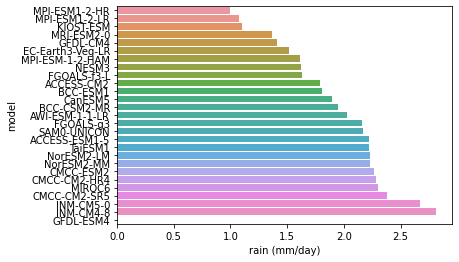

In [11]:
%%time
# Read csv as Dask dataframe
dd = dd.read_csv('figsharerainfall/combined_data.csv')
dd_plot = dd.groupby('model')['rain (mm/day)'].mean().compute()
dd_plot = dd_plot.to_frame().sort_values('rain (mm/day)')

# Plot
sns.barplot(data=dd_plot, x = 'rain (mm/day)', y = dd_plot.index)

| Team Member       | Operating System | RAM  | Processor | Is SSD | Time taken |
|-------------------|------------------|------|-----------|--------|------------|
| Karanpreet Kaur   |                  |      |           |        |            |
| Melisa Maidana    | mac              | 8 GB | M1        | yes    |            |
| Nagraj Rao        |                  |      |           |        |            |
| Ting Zhe (TZ) Yan | mac              | 8 GB | M1        | yes    |            |

### 6. Perform a simple EDA in R

#### Approach to transfer the dataframe from python to R

#### Discuss why you chose this approach over others

#### Summary of results

| Team Member       | Operating System | RAM  | Processor | Is SSD | Time taken |
|-------------------|------------------|------|-----------|--------|------------|
| Karanpreet Kaur   |                  |      |           |        |            |
| Melisa Maidana    | mac              | 8 GB | M1        | yes    |            |
| Nagraj Rao        |                  |      |           |        |            |
| Ting Zhe (TZ) Yan | mac              | 8 GB | M1        | yes    |            |